In [1]:
import numpy as np
from matplotlib import pyplot as plt


In [2]:
class Agent:
    def choose_action(self,state):
        action = 0
        if np.random.uniform(0,1) < self.epsilon:
            action = self.action_space.sample()
        else:
            action = np.argmax(self.Q[state])
        return action
class DoubleLearningAgent:
    def choose_action(self,state):
        action = 0
        if np.random.uniform(0,1) < self.epsilon:
            action = self.action_space.sample()
        else:
            action = np.argmax(self.Q1[state]+self.Q2[state])
        return action

In [3]:
class SarsaAgent(Agent):
    def __init__(self,epsilon,alpha,gamma,num_states,num_actions,action_space):
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.num_states = num_states
        self.num_actions = num_actions
        self.action_space = action_space
        
        self.Q = np.zeros((num_states,num_actions))
        self.action_space = action_space
        
    def update(self,prev_state,prev_action,reward,next_state,next_action):
        prediction = self.Q[prev_state,prev_action]
        target = reward + self.gamma * self.Q[next_state,next_action]
        error = target - prediction
        self.Q[prev_state,prev_action] += self.alpha * error
    

In [4]:
class QLearningAgent(Agent):
    def __init__(self,epsilon,alpha,gamma,num_states,num_actions,action_space):
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.num_states = num_states
        self.num_actions = num_actions
        self.action_space = action_space
        
        self.Q = np.zeros((num_states,num_actions))
        self.action_space = action_space
        
    def update(self,prev_state,prev_action,reward,next_state,next_action):
        prediction = self.Q[prev_state,prev_action]
        target = reward + self.gamma * np.max(self.Q[next_state,:])
        error = target - prediction
        self.Q[prev_state,prev_action] += self.alpha * error

In [5]:
class ExpectedSarsa(Agent):
    def __init__(self,epsilon,alpha,gamma,num_states,num_actions,action_space):
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.num_states = num_states
        self.num_actions = num_actions
        self.action_space = action_space
        
        self.Q = np.zeros((num_states,num_actions))
        self.action_space = action_space
        
    def update(self,prev_state,prev_action,reward,next_state,next_action):
        prediction = self.Q[prev_state,prev_action]
        expected_q = 0
        for i in range(self.num_actions):
            expected_q += self.Q[next_state][i] * (1/self.num_actions)
        target = reward + self.gamma * expected_q    
        
        error = target - prediction
        self.Q[prev_state,prev_action] += self.alpha * error

In [6]:
class DoubleQLearningAgent(DoubleLearningAgent):
    def __init__(self,epsilon,alpha,gamma,num_states,num_actions,action_space):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.num_states = num_states
        self.num_actions = num_actions
        self.action_space = action_space
        
        self.Q1 = np.zeros((num_states,num_actions))
        self.Q2 = np.zeros((num_states,num_actions))

        self.action_space = action_space
    def update(self,prev_state,prev_action,reward,next_state,next_action):
        if np.random.uniform(0,1) < .5:
            prediction = self.Q1[prev_state,prev_action]
            target = reward + gamma*self.Q2[next_state,np.argmax(self.Q1[next_state,:])]
            error = target - prediction
            self.Q1[prev_state,prev_action] += self.alpha * error
        else:
            prediction = self.Q2[prev_state,prev_action]
            target = reward + gamma*self.Q1[next_state,np.argmax(self.Q2[next_state,:])]
            error = target - prediction
            self.Q2[prev_state,prev_action] += self.alpha * error

In [7]:
import gym
import math
env = gym.make('CliffWalking-v0') 

epsilon = .1
total_episodes = 500
max_steps = 500
gamma = 1
alpha = .5

MIN_EXPLORE_RATE = 0.01
MIN_LEARNING_RATE = 0.2

sarsaAgent = SarsaAgent(epsilon,alpha,gamma,env.observation_space.n,env.action_space.n,env.action_space)
qAgent = QLearningAgent(epsilon,alpha,gamma,env.observation_space.n,env.action_space.n,env.action_space)
expectedSarsa = ExpectedSarsa(epsilon,alpha,gamma,env.observation_space.n,env.action_space.n,env.action_space)
doubleQLearning = DoubleQLearningAgent(epsilon,alpha,gamma,env.observation_space.n,env.action_space.n,env.action_space)
agents = [sarsaAgent,qAgent,expectedSarsa,doubleQLearning]

alphas = [.25,.5,.75,1]

results = {
    'SarsaAgent': [],
    'QLearningAgent': [],
    'ExpectedSarsa': [],
    'DoubleQLearningAgent': []
}

for alpha in alphas: 
    episodeReward = 0
    totalReward = {
        'SarsaAgent':[],
        'QLearningAgent':[],
        'ExpectedSarsa': [],
        'DoubleQLearningAgent': []
    }
    for agent in agents:
        agent.alpha = alpha
        for episode in range(total_episodes):
            t = 0
            state = env.reset()
            action = agent.choose_action(state)
            episode_reward = 0
            while t < max_steps:
                next_state,reward,done,info = env.step(action)     
                next_action = agent.choose_action(next_state)

                agent.update(state,action,reward,next_state,next_action)

                state = next_state
                action = next_action

                t += 1
                episode_reward += reward

                if done:
                    break
            totalReward[type(agent).__name__].append(episode_reward)

    results['SarsaAgent'].append(np.mean(totalReward['SarsaAgent']))
    results['QLearningAgent'].append(np.mean(totalReward['QLearningAgent']))
    results['ExpectedSarsa'].append(np.mean(totalReward['ExpectedSarsa']))
    results['DoubleQLearningAgent'].append(np.mean(totalReward['DoubleQLearningAgent']))
env.close() 

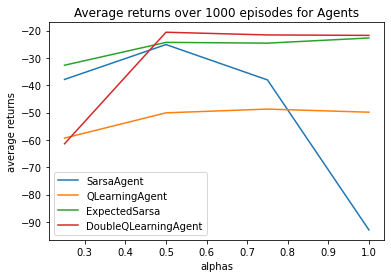

In [8]:
for agent in agents:
    plt.plot(alphas,results[type(agent).__name__],label=type(agent).__name__)
plt.xlabel("alphas")
plt.ylabel("average returns")
plt.title("Average returns over 1000 episodes for Agents")
plt.legend()
plt.show()

- Sarsa can only perform well for small alphas
- Expected Sarsa can safely set alpha = 1 without suffering any degredation of performance
- TD algos (Q-Learning) usesa a maximization operation, which leads to a maximization bias. For instance, consider q(s,a) = 0; Q(s,a) is uncertain and has a positive bias. Most of true values is zero, but the max Q(s,a) is positive, hence we have a positive bias. The maximization bias occurs because we use the same samples to determine the maximizng action and its value. We solve this over time by using 2 diff Q funcs Q1,Q2 to determine max action and value and then switching them overtime. In this CliffWalking example the DoubleQLearningAgent performs significantly better than its QLearningAgent counterpart.

In [9]:
for agent in agents:
    print(type(agent).__name__,results[type(agent).__name__])

SarsaAgent [-37.87, -25.116, -38.044, -92.91]
QLearningAgent [-59.324, -50.086, -48.716, -49.856]
ExpectedSarsa [-32.668, -24.312, -24.6, -22.71]
DoubleQLearningAgent [-61.4, -20.61, -21.594, -21.76]
